In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Experiment 1 vs. legacy
# 1.0.0 (loss = 95)
# 1.0.1 (loss = 71)
# 1.0.2 (loss = 68)
# 1.0.3 (loss = 90) (range: -10,000 - 10,000)

# Experiment 2 vs. legacy-1 (accurate item price readings)
# 1.0.4 (loss = 142000, loss / mean_pred = 2.76) (range: -1000 - 1500) (dep_var = weighted_profit)

# Experiment 3 - (1.0.5 vs 1.1.0) (weighted_profit vs gst)
# 1.0.5 - (dep_var = weighted_profit) (range: [-400, 700]) (loss = 92000, loss / mean_pred = 2.06)
# 1.1.0 - (dep_var = gst) (range: [-400, 700]) (loss = 54, loss / mean_pred = 1.74)
# 1.1.0 wins

# Experiment 4 - (1.1.1 vs 1.2.0) (gst RF vs. gst NN)
# 1.1.1 - (dep_var = gst) (range: [-400, 700]) (loss = 70, loss / mean_pred = 1.43)
# 1.2.0 - (dep_var = gst) (range: [-400, 700]) (loss = 77, loss / mean_pred = 1.56)

model_version = '1.1.1'
model_can_be_dumped = True
dep_var = 'gst'
min_samples_leaf_param = 5
max_features_param = 'sqrt'
num_est = 80
validation_lookback = 7
train_start_days_past = 63
wanted_columns = [
    "high_price_1h",
    "high_price_5m",
    "high_volume_1h",
    "high_volume_5m",
    "low_price_1h",
    "low_price_5m",
    "low_volume_1h",
    "low_volume_5m",
    "player_count",
    "timestampElapsed"
  ]

In [3]:
path = Path.cwd()
Path.BASE_PATH = path
dsets_path = path.parent.parent/'fastai/datasets'
path.ls()

(#6) [Path('preprocessed_train_valid.pkl'),Path('random_forest.ipynb'),Path('.ipynb_checkpoints'),Path('decision_tree.ipynb'),Path('xg_boost.ipynb'),Path('neural_net.ipynb')]

In [4]:
df = pd.read_csv(dsets_path/'osrs_trades.csv', low_memory=False)
make_date(df, 'timestamp')
df = add_datepart(df, 'timestamp')

/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


Index(['id', 'item_id', 'gst', 'player_count', 'profit', 'high_price_5m',
       'low_price_5m', 'high_volume_5m', 'low_volume_5m', 'high_price_1h',
       'low_price_1h', 'high_volume_1h', 'low_volume_1h', 'high_vol_mavg_1h',
       'low_vol_mavg_1h', 'vol_ratio_1h', 'vol_ratio_5m', 'price_ratio_5m',
       'price_ratio_1h', 'avg_price_5m', 'avg_price_1h', 'high_vol_ratio',
       'low_vol_ratio', 'high_price_ratio', 'low_price_ratio',
       'avg_price_ratio', 'high_vol_differential', 'normalized_gst',
       'weighted_profit', 'timestampYear', 'timestampMonth', 'timestampWeek',
       'timestampDay', 'timestampDayofweek', 'timestampDayofyear',
       'timestampIs_month_end', 'timestampIs_month_start',
       'timestampIs_quarter_end', 'timestampIs_quarter_start',
       'timestampIs_year_end', 'timestampIs_year_start', 'timestampElapsed'],
      dtype='object')

In [5]:
procs = [Categorify, FillMissing]
max_day = df["timestampDayofyear"].max()
minCond = (df.timestampDayofyear>(max_day - train_start_days_past)) # day 117 is when I fixed date recording on completed_trades
maxCond = (df.timestampDayofyear<=(max_day - validation_lookback))
train_idx = np.where((maxCond) & (minCond))[0]
valid_idx = np.where(~maxCond)[0]

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(path/'preprocessed_train_valid.pkl', to)

/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [6]:
to = load_pickle(path/'preprocessed_train_valid.pkl')

In [7]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [8]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [9]:
def rf(xs, y, n_estimators=num_est,
       max_features=max_features_param, min_samples_leaf=min_samples_leaf_param, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [10]:
m = rf(xs, y)

In [11]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [12]:
fi = rf_feat_importance(m, xs)

In [13]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [14]:
# to_keep = fi[fi.imp>0.02].cols
# xs_imp = xs[to_keep]
# valid_xs_imp = valid_xs[to_keep]

xs_imp = xs
valid_xs_imp = valid_xs

def drop_unwanted_columns(df, required_columns):
  df = df[required_columns]
  return df
    
xs_imp = drop_unwanted_columns(xs_imp, wanted_columns)
valid_xs_imp = drop_unwanted_columns(valid_xs_imp, wanted_columns)
    
xs_imp = xs_imp.sort_index(axis=1)
valid_xs_imp = valid_xs_imp.sort_index(axis=1)

m = rf(xs_imp, y)
mean_rmse = m_rmse(m, valid_xs_imp, valid_y)
mean_rmse, mean_rmse / valid_y.mean()

(70.448303, 1.4282372157612189)

In [15]:
preds = np.stack([t.predict(valid_xs_imp) for t in m.estimators_])

/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tristan/Docume

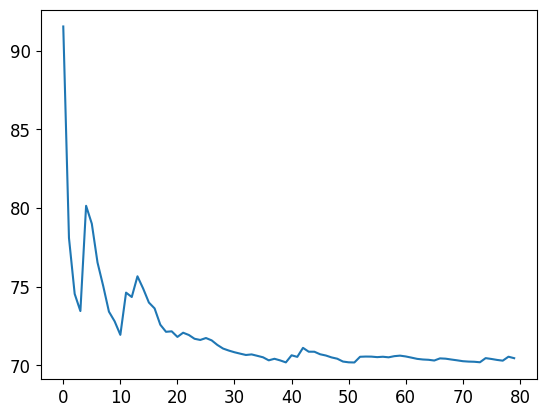

In [16]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(num_est)]);

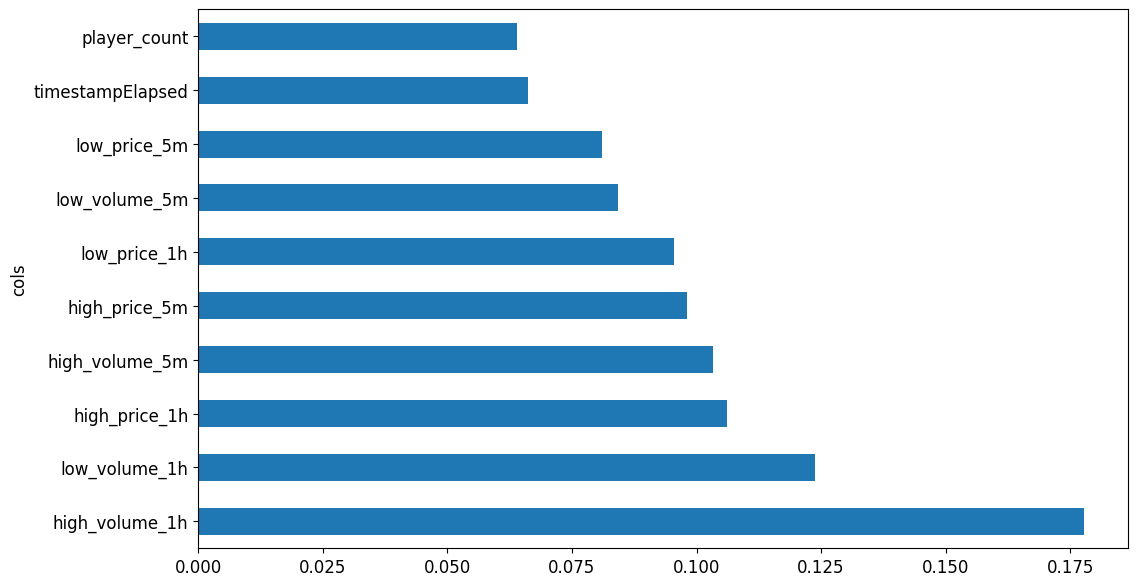

In [17]:
plot_fi(rf_feat_importance(m, xs_imp));

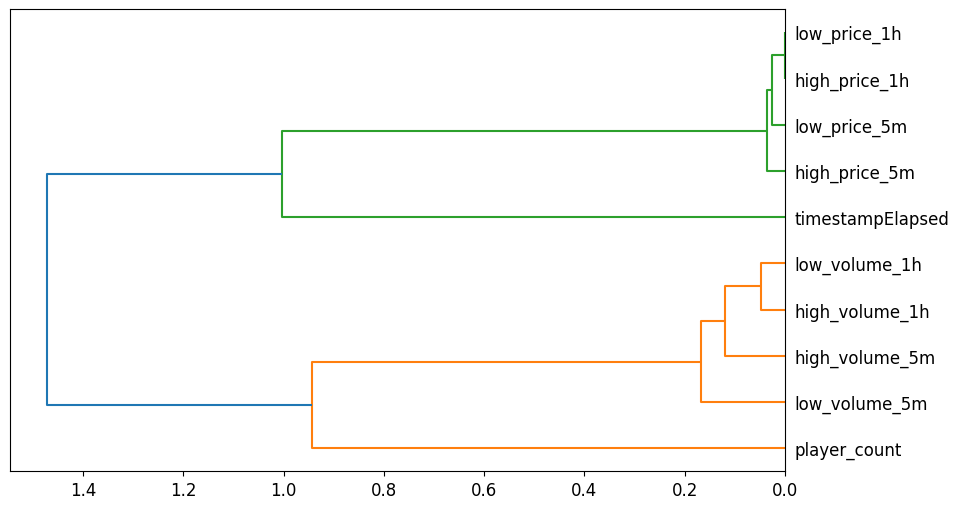

In [18]:
cluster_columns(xs_imp)

In [19]:
m.predict(valid_xs_imp.head(n=10))

array([ 38.40145575,  56.83026981,  47.20560071,  29.61170308,  38.51225927,  43.18212231,  82.363782  ,  52.89145067,  55.11182074, 174.69498161])

In [20]:
valid_y.head(n=10)

15872     30.100000
15873      0.070000
15874    110.129997
15875     54.730000
15876     64.180000
15877     35.660000
15878     19.639999
15879     80.000000
15880    200.000000
15881    200.910004
Name: gst, dtype: float32

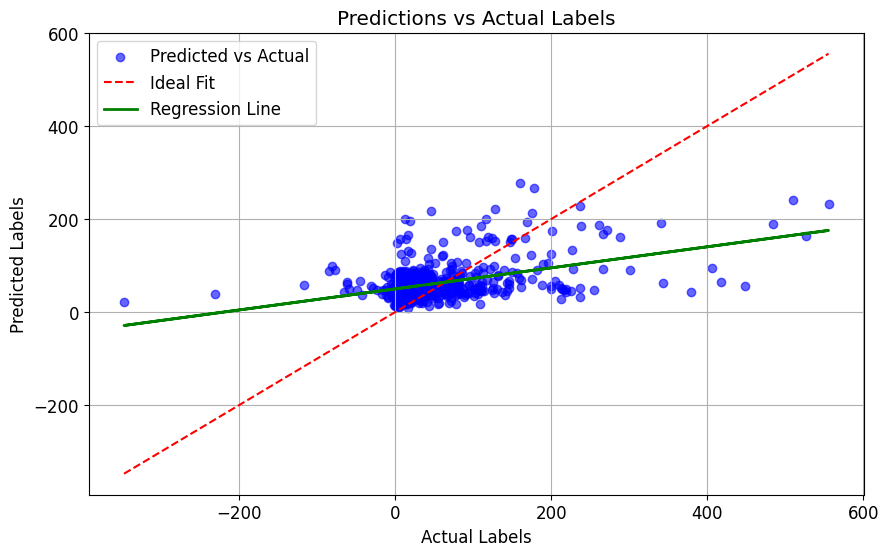

In [21]:
y_pred = m.predict(valid_xs_imp)

slope, intercept = np.polyfit(valid_y, y_pred, 1)
reg_line = slope * np.array(valid_y) + intercept

plt.figure(figsize=(10, 6))
plt.scatter(valid_y, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(valid_y), max(valid_y)], [min(valid_y), max(valid_y)], color='red', linestyle='--', label='Ideal Fit')
plt.plot(valid_y, reg_line, color='green', linestyle='-', linewidth=2, label='Regression Line')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actual Labels')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
xs_imp.columns

Index(['high_price_1h', 'high_price_5m', 'high_volume_1h', 'high_volume_5m',
       'low_price_1h', 'low_price_5m', 'low_volume_1h', 'low_volume_5m',
       'player_count', 'timestampElapsed'],
      dtype='object')

In [23]:
if model_can_be_dumped:
    joblib.dump(m, f'/home/tristan/Documents/dev/ge_bot/prediction_api/{model_version}.pkl')
    print("dumped new model")
else:
    print("did not dump new model")

dumped new model


In [24]:
# xs_imp.iloc[-1].to_dict()